In [4]:
!pip install tensorflow keras

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/376.0 MB 3.4 MB/s eta 0:01:52
   ---------------------------------------- 1.3/376.0 MB 3.4 MB/s eta 0:01:52
   ---------------------------------------- 2.1/376.0 MB 3.7 MB/s eta 0:01:42
   ---------------------------------------- 3.1/376.0 MB 4.2 MB/s eta 0:01:29
   ---------------------------------------- 3.7/376.0 MB 3.9 MB/s eta 0:01:36
    --------------------------------------- 5.2/376.0 MB 4.5 MB/s eta 0:01:23
    --------------------------------------- 6.8/376.0 MB 5.0 MB/s eta 0:01:14
    -------------------

In [45]:
import pandas as pd # read the csv
import re # regex to detect username, url, html entity 
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
import tensorflow.keras.backend as keras

In [46]:
os.getcwd()
data = pd.read_csv("train.csv")

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [47]:
# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {data.shape}")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (24783, 6)


In [48]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
#note : all of the function taking 1 text at a time
stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [50]:
nltk.download('punkt_tab')
clean_tweet = preprocess(tweet)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [85]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)
## Tokenizing -> basically we use tokenisation for many things, its commonly used for feature extraction in preprocessing. btw idk how it works as feature extraction tho :(
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)
print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
# Custom F1 Score using class-based metric (avoids tf.function error)
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()



# change dis if u want
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',F1Score(),Precision(name="precision"), Recall(name="recall")])
model.summary()
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=7,
    validation_data=(X_test, y_test)
)

num test tweet: 4957
num train tweet: 19826


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

X_train shape: (19826, 26)
y_train shape: (19826, 3)
X_test shape: (4957, 26)
y_test shape: (4957, 3)
Epoch 1/7
310/310 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.7942 - f1_score: 0.9672 - loss: 0.6095 - precision: 0.8161 - recall: 0.6928 - val_accuracy: 0.8897 - val_f1_score: 0.9699 - val_loss: 0.3227 - val_precision: 0.9035 - val_recall: 0.8802
Epoch 2/7
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9166 - f1_score: 0.9706 - loss: 0.2517 - precision: 0.9269 - recall: 0.9078 - val_accuracy: 0.8899 - val_f1_score: 0.9675 - val_loss: 0.3186 - val_precision: 0.8989 - val_recall: 0.8794
Epoch 3/7
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9434 - f1_score: 0.9763 - loss: 0.1599 - precision: 0.9490 - recall: 0.9390 - val_accuracy: 0.8858 - val_f1_score: 0.9672 - val_loss: 0.3722 - val_precision: 0.8911 - val_recall: 0.8844
Epoch 4/7
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9621 - f1_score: 0.9836 - loss: 0.1080 - precision: 0.9632 - recall: 0.9607

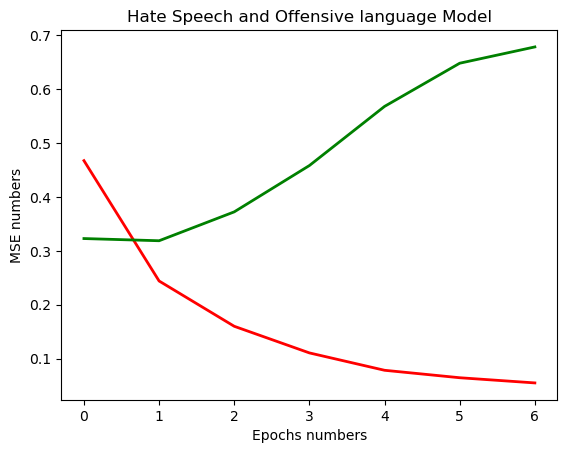

In [86]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [87]:
# --- Preprocessing function for a single input ---
def preprocess_single_tweet(tweet):
    tweet = change_user(tweet)
    tweet = remove_entity(tweet)
    tweet = remove_url(tweet)
    tweet = remove_noise_symbols(tweet)
    tweet = remove_stopwords(tweet)
    return tweet

# --- Prediction function for a single tweet ---
def predict_tweet(tweet, tokenizer, model, max_length):
    # Clean the tweet
    cleaned = preprocess_single_tweet(tweet)
    
    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=max_length)
    
    # Predict
    prediction = model.predict(padded)
    predicted_class = prediction.argmax(axis=-1)[0]

    # Class labels (adjust if your dataset uses different meanings)
    label_map = {0: "Hate Speech", 1: "Offensive Language", 2: "Neutral"}

    # Output result
    print("\n=== Prediction ===")
    print(f"Original Tweet: {tweet}")
    print(f"Cleaned Tweet: {cleaned}")
    print(f"Predicted Class: {predicted_class} ({label_map[predicted_class]})")
    print(f"Confidence Scores: {prediction[0]}")


In [88]:
# --- Input from user ---
user_input = input("Enter a tweet to classify: ")

predict_tweet(user_input, tokenizer, model, max_length)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step

=== Prediction ===
Original Tweet: Hello
Cleaned Tweet: Hello
Predicted Class: 2 (Neutral)
Confidence Scores: [0.3872162  0.05487511 0.55790865]


In [89]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [90]:
model.save("hate_speech_model.h5")
